# **Introduction**

This project involves two major tasks: training a neural network for binary classification and implementing convolution operations for time series and image data.  

**Part 1: Neural Network for Diabetes Prediction**  

In the first part, we will build and train a neural network for binary classification using a medical dataset from the National Institute of Diabetes and Digestive and Kidney Diseases. The dataset aims to diagnostically predict whether a patient has diabetes based on specific medical measurements. The dataset includes several predictor variables, such as:  

- **Pregnancies** (numeric): Number of times the patient has been pregnant.  
- **Glucose** (numeric): Plasma glucose concentration.  
- **BloodPressure** (numeric): Diastolic blood pressure (mm Hg).  
- **SkinThickness** (numeric): Triceps skinfold thickness (mm).  
- **Insulin** (numeric): Serum insulin (mu U/ml).  
- **BMI** (numeric): Body mass index (weight in kg/(height in m)^2).  
- **DiabetesPedigreeFunction** (numeric): Diabetes hereditary risk score.  
- **Age** (numeric): Patient's age in years.  
- **Outcome** (categorical): Target variable indicating diabetes diagnosis (1 = Yes, 0 = No).  

The goal is to develop a model that accurately predicts the likelihood of diabetes based on these features.  

**Part 2: Convolution Operations**

After training the neural network, we will explore 1D and 2D convolution operations through two key tasks:  

1. **1D Convolution for Time Series Data**  
   - Apply convolution for time series data, commonly used for denoising signals.  
   - Experiment with different kernel sizes to observe the trade-offs between large and small kernels in terms of smoothing and information retention.  

2. **2D Convolution for Image Processing**  
   - Implement a convolution function without using deep learning libraries (e.g., TensorFlow, PyTorch, Keras).  
   - The function will take an input image of shape **(C × H × W)** and apply a kernel-based convolution to generate an output image.  
   - If the kernel size exceeds the image dimensions (e.g., a 30×30 kernel for a 28×28 image), the function should return an error.  
   - Padding will not be implemented in this task.

# **Importing Libraries**

Before we start our project, let's first import all the sufficiencies that will help us throughout the project

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid',palette='viridis')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from torchmetrics.classification import BinaryAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics
import cv2
from PIL import Image

# **Part 1 - Neural Network for Diabetes Prediction**

## **Data Inspection and EDA**

First let's import our data and label them

In [2]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

df = pd.read_csv(url, header=None, names=col_names)

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

So here we have dataset with 8 feature and 1 target variables with 768 instances

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


All of the variables are numberical, and we don't have any null values, which needs double check because there could be zeros or some other variables that would indicate the abscence of value

In [6]:
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


As we can see the target variable is not perfectly balanced, but to be honest its pretty alright

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


As I already mentioned even though we don't have any null values in our dataset, there are some suspicious columns that should not suppose to have 0s as their minimal values, and those columns are:
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

None of this indicators are possible to be 0 for a living human, according to the medical articles, which means that we consider them as a null values and impute them. I will define it in a function so we can use it in our pipeline

In [8]:
def fix_nas(df: pd.DataFrame) -> pd.DataFrame:
    df['Glucose'] = df['Glucose'].replace(0, np.nan)
    df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
    df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
    df['Insulin'] = df['Insulin'].replace(0, np.nan)
    df['BMI'] = df['BMI'].replace(0, np.nan)

    df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
    df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
    df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].median())
    df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median())
    df['BMI'] = df['BMI'].fillna(df['BMI'].median())

    return df

Now let's check our data's distributions and their correlation

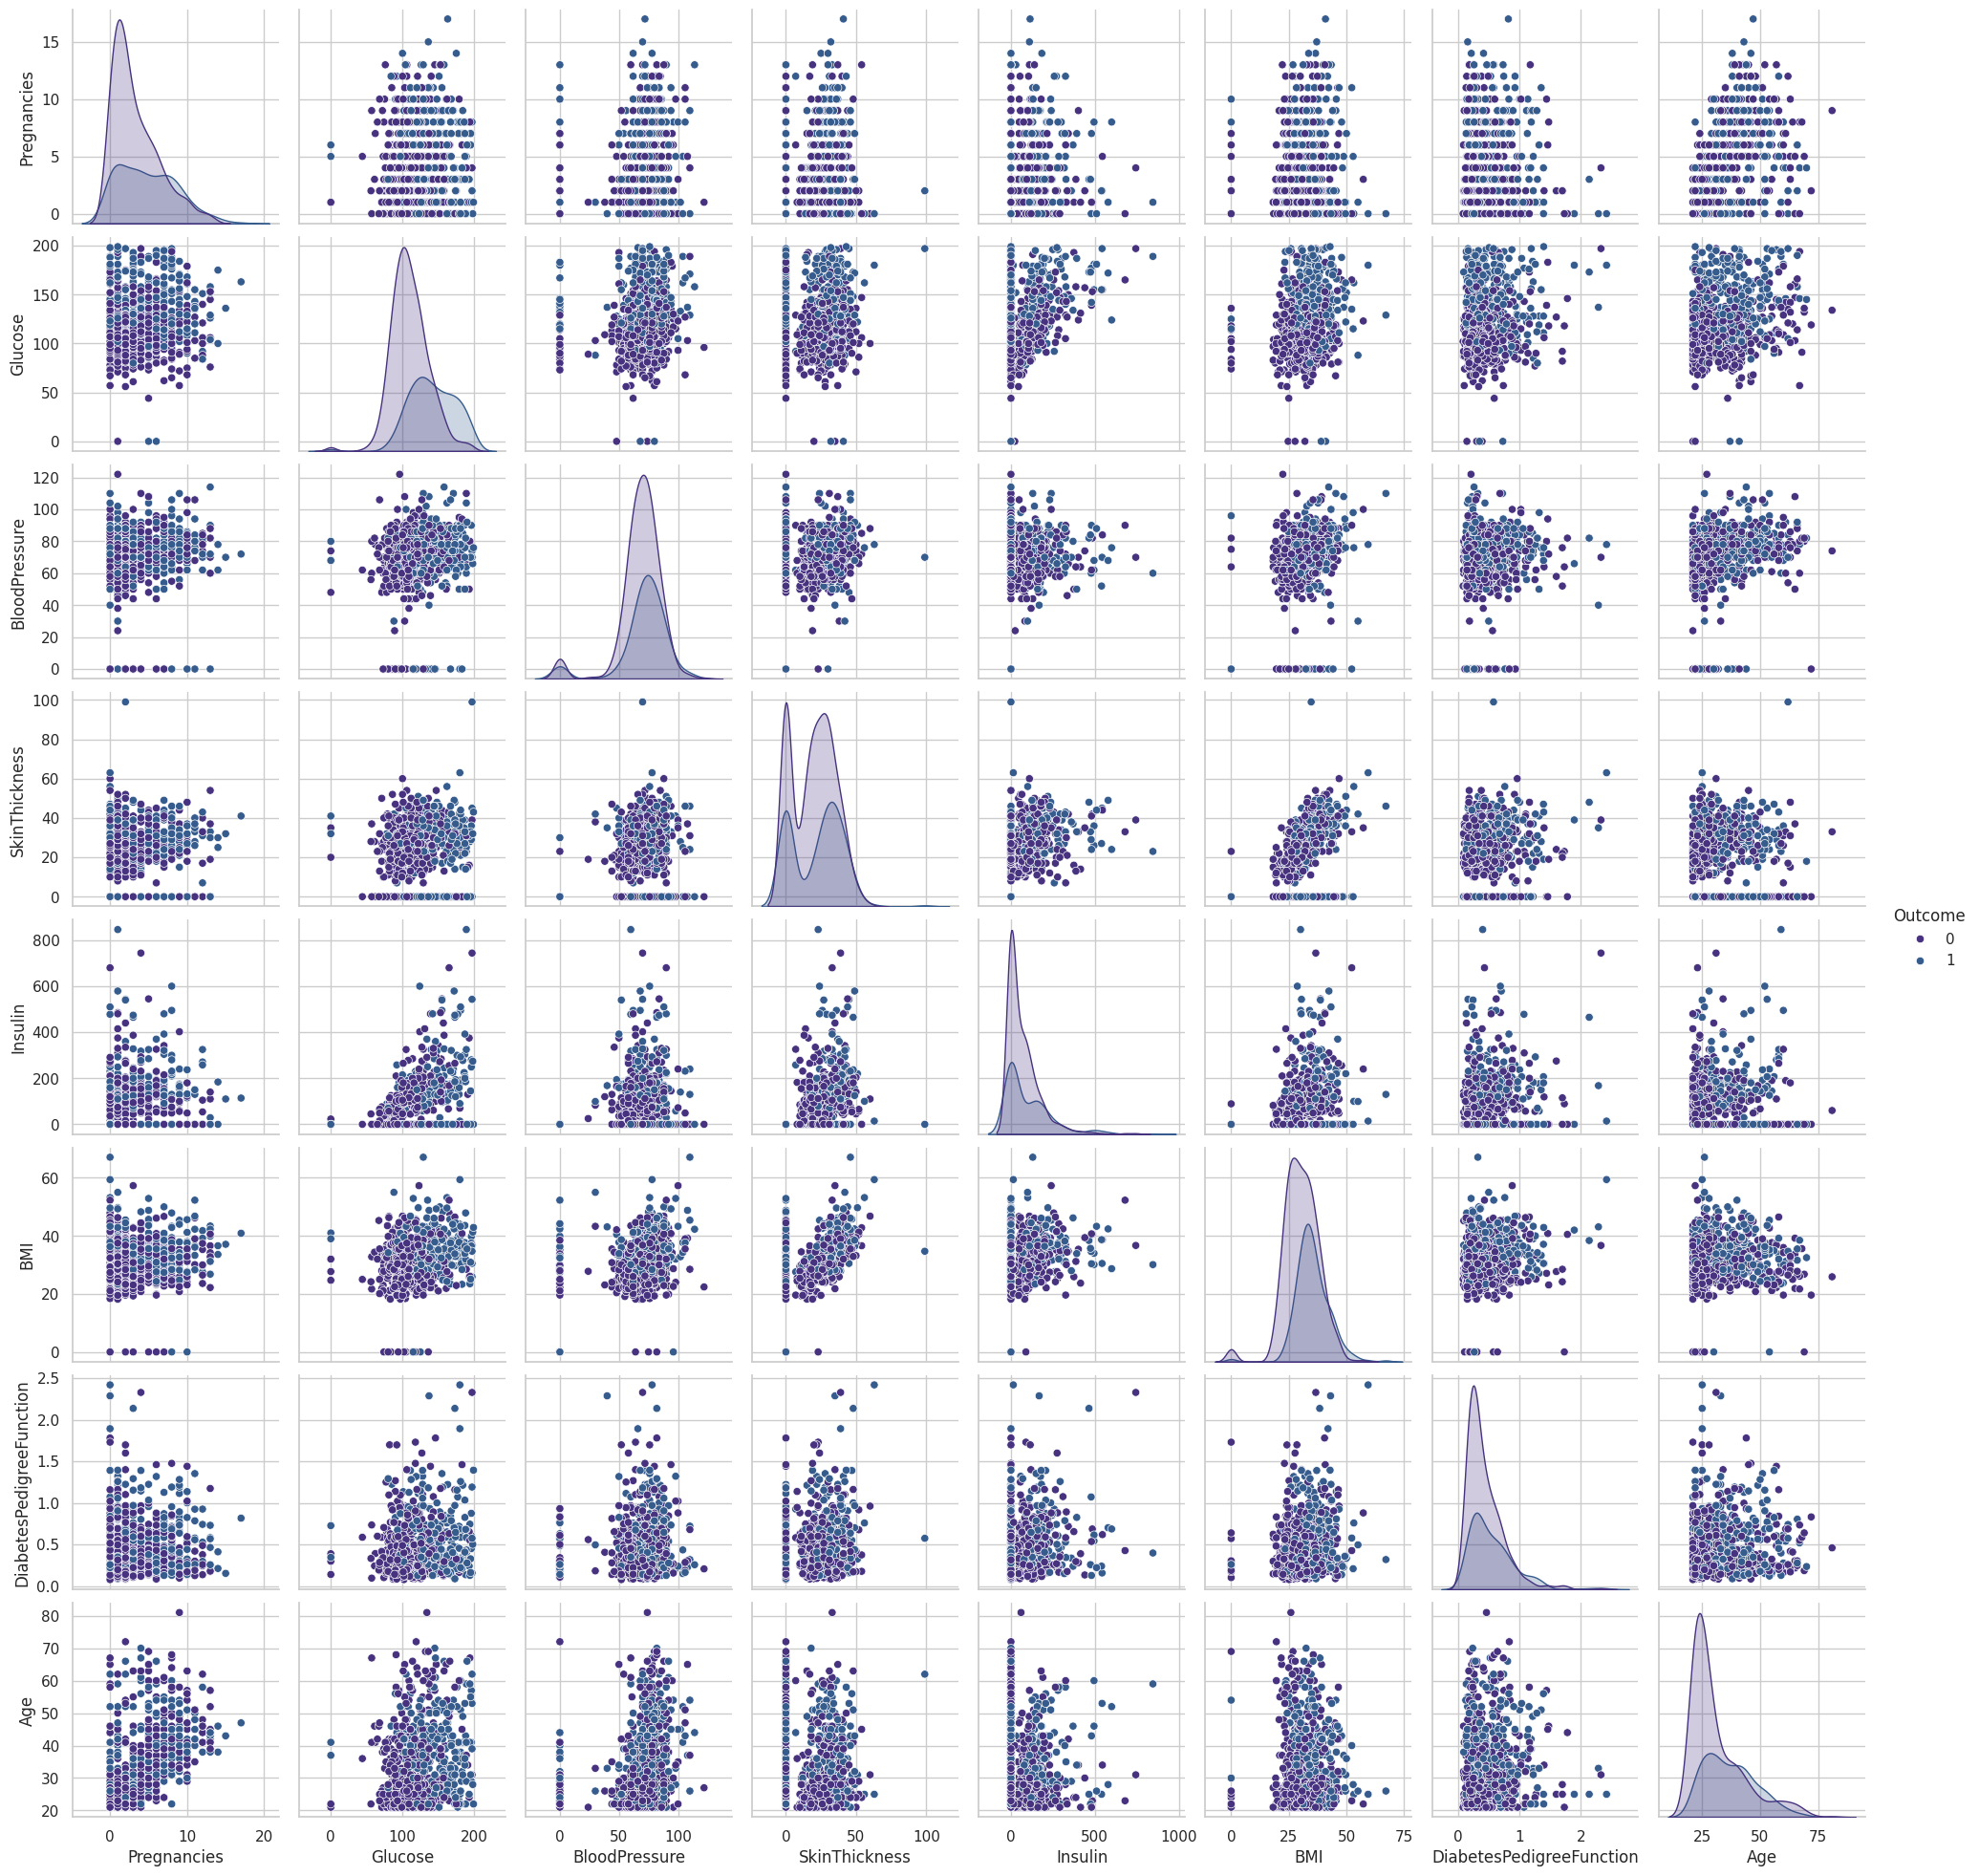

In [9]:
sns.pairplot(df, hue='Outcome')

Text(0.5, 1.0, 'Correlation Heatmap')

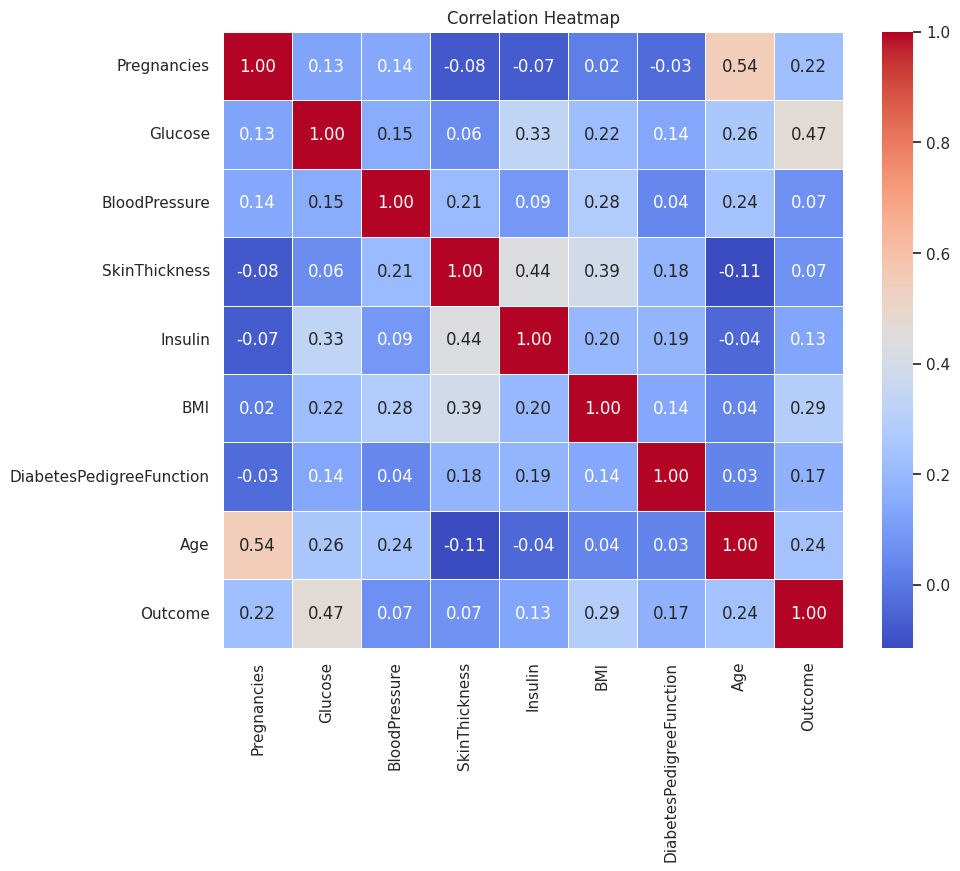

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")

We don't have any anomalys here, everything seems to have explanatory distributions with mostly positive skews and none of the variables have any significant correlation that should be emphasized

## **Pipeline For Data Preparation**

As we have already defined our imputation step, let's do our next pipeline steps, such as data scaling, validation splitting, conversion to tensors and preparation of our torch dataloader

In [11]:
def scale_data(X_train, X_test) -> pd.DataFrame:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

Scaling done!

In [12]:
def split_data(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    X = df[feature_names].values
    y = df["Outcome"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

Cross-validation done!

In [13]:
def convert_to_tensors(X_train, y_train, X_test, y_test):
    train_tensors = (torch.tensor(X_train, dtype=torch.float32),
                     torch.tensor(y_train, dtype=torch.float32))
    test_tensors = (torch.tensor(X_test, dtype=torch.float32),
                    torch.tensor(y_test, dtype=torch.float32))
    return *train_tensors, *test_tensors

Conversion to tensors done!

In [14]:
def prepare_dataloader(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, batch_size):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Since we defined all the steps let's build our pipeline

In [15]:
def data_pipeline(df: pd.DataFrame, batch_size: int):
    features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
    df = fix_nas(df)
    X_train, X_test, y_train, y_test = split_data(df, features)
    X_train, X_test = scale_data(X_train, X_test)
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train, y_train, X_test, y_test)
    train_loader, test_loader = prepare_dataloader(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, batch_size)
    return train_loader, test_loader

Done! Its time to build our network


## **Neural Network Building and Evaluation**

It is hard to guess what kind of architecture and hyperparameters would give us the best results, so I think it would be a good idea to try out different types of architectures and find the best performer.

I will create 3 types of architecture models:

- Baseline Model: A simple architecture with moderate neuron counts

- Deep Model: More layers and neurons to test depth effects

- Wider Model: Fewer layers but with significantly more neurons per layer

For each of these architectures I will use In my opinion the most common and also the most suitable hyperparameters, which are:

- **Learning rate = 0.0005** - with Adam optimizer, Adam is adaptive optimizer and it works with different learning rates and 0.001 is a common default choice so but since I got too wiggly learning curve on the 0.001 I will stick to the 0.0005
- **Loss function = BCELoss** - since we have a binary classification task, Binary Cross-Entropy is obviously the most suitable choice
- **Epochs = 30** - I tried 50 epochs by myself and it just did not really change its loss after 30 epochs, it just got wiggly and non-stable so I thought 30 epochs is the best choice, we will see that on the learning curve as well
- **Batch size = 64** - 64 batches is pretty standard choice its pretty efficient and yields a stable gradient
- **Activation Functions = ReLU & Sigmoid** - for the hidden layers ReLU is always the most recommended one, so I will stick with it and for the output layer I chose sigmoid, because we have a binary classification task

In [16]:
class DiabetesNN_Baseline(nn.Module):
    def __init__(self):
        super(DiabetesNN_Baseline, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

class DiabetesNN_Deep(nn.Module):
    def __init__(self):
        super(DiabetesNN_Deep, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

class DiabetesNN_Wide(nn.Module):
    def __init__(self):
        super(DiabetesNN_Wide, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Since we have created all of 3 classes for our different types of architetcures, now its time to train and evaluate all these models to find out which one performs the best

In [17]:
def train_model(model, train_loader, criterion, optimizer, device, track_loss=False):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    epoch_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())
        predicted = (outputs.squeeze() > 0.5).float()
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds

    if track_loss:
        return epoch_loss, epoch_accuracy, epoch_losses
    return epoch_loss, epoch_accuracy

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct_preds / total_preds
    return epoch_loss, epoch_accuracy

def train_and_evaluate_models(train_loader, test_loader, device, batch_size=64, epochs=30):
    models = {
        'Baseline': DiabetesNN_Baseline().to(device),
        'Deep': DiabetesNN_Deep().to(device),
        'Wide': DiabetesNN_Wide().to(device),
    }

    results = {}
    baseline_losses = []

    for model_name, model in models.items():
        print(f"Training {model_name} Model...")

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0005)

        for epoch in range(epochs):
            if model_name == 'Baseline':
                train_loss, train_accuracy, epoch_losses = train_model(
                    model, train_loader, criterion, optimizer, device, track_loss=True
                )
                baseline_losses.append(train_loss)
            else:
                train_loss, train_accuracy = train_model(
                    model, train_loader, criterion, optimizer, device
                )

            print(f"Epoch {epoch+1}/{epochs} - {model_name} - Training Loss: {train_loss:.4f} "
      f"- Training Accuracy: {train_accuracy:.4f}")

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

        results[model_name] = {'Test Loss': test_loss, 'Test Accuracy': test_accuracy}

    return results, baseline_losses

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = data_pipeline(df, batch_size=32)
    results, baseline_losses = train_and_evaluate_models(train_loader, test_loader,
                                                         device, batch_size=64, epochs=30)
    best_model = min(
        results, key=lambda x: results[x]['Test Loss']
    )
    print(
        f"\nBest Model: {best_model} with Test Loss: {results[best_model]['Test Loss']:.4f} "
        f"and Test Accuracy: {results[best_model]['Test Accuracy']:.4f}"
    )


Training Baseline Model...
Epoch 1/30 - Baseline - Training Loss: 0.6809 - Training Accuracy: 0.6270
Epoch 2/30 - Baseline - Training Loss: 0.6650 - Training Accuracy: 0.6792
Epoch 3/30 - Baseline - Training Loss: 0.6533 - Training Accuracy: 0.6922
Epoch 4/30 - Baseline - Training Loss: 0.6392 - Training Accuracy: 0.7134
Epoch 5/30 - Baseline - Training Loss: 0.6229 - Training Accuracy: 0.7264
Epoch 6/30 - Baseline - Training Loss: 0.6025 - Training Accuracy: 0.7313
Epoch 7/30 - Baseline - Training Loss: 0.5786 - Training Accuracy: 0.7541
Epoch 8/30 - Baseline - Training Loss: 0.5632 - Training Accuracy: 0.7671
Epoch 9/30 - Baseline - Training Loss: 0.5314 - Training Accuracy: 0.7704
Epoch 10/30 - Baseline - Training Loss: 0.5142 - Training Accuracy: 0.7671
Epoch 11/30 - Baseline - Training Loss: 0.4941 - Training Accuracy: 0.7687
Epoch 12/30 - Baseline - Training Loss: 0.4867 - Training Accuracy: 0.7687
Epoch 13/30 - Baseline - Training Loss: 0.4750 - Training Accuracy: 0.7655
Epoch 1


The results of the model evaluations show that the Baseline model outperformed both the Deep and Wide models in terms of accuracy, achieving 0.78 accuracy. The Deep model achieved an accuracy of 0.746, while the Wide model performed slightly worse with an accuracy of 0.74. These findings suggest that the simpler architecture of the Baseline model is more effective for this specific task compared to the deeper and wider models.

Now let's check our learning curve for the baseline model to see if we chose the number of epochs correctly

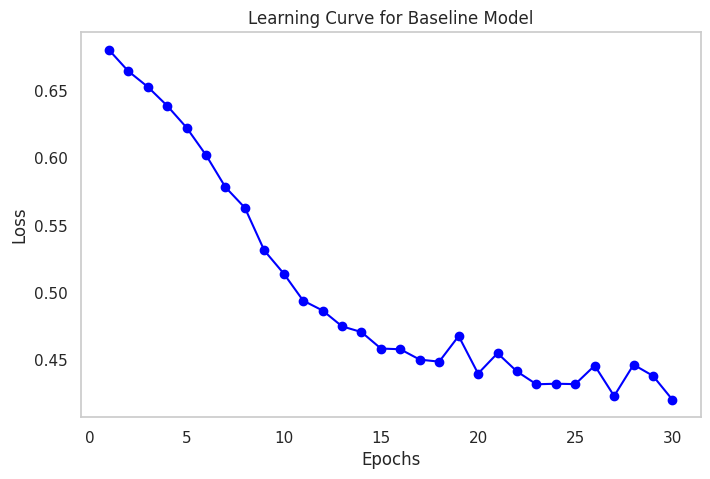

In [18]:
def plot_learning_curve(baseline_losses, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), baseline_losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve for Baseline Model')
    plt.grid()

plot_learning_curve(baseline_losses, epochs=30)

So our learning curve is little bit wiggly, but the 30 epochs seem to be a reasonable decision because it is where our loss gets to almost the minimal point

Now its time to build and train our data on neural network built with Pytorch Lightning

In [19]:
class DiabetesNN_Baseline_Lightning(pl.LightningModule):
    def __init__(self):
        super(DiabetesNN_Baseline_Lightning, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.loss_fn = nn.BCELoss()
        self.accuracy = torchmetrics.Accuracy(task='binary')

        self.validation_step_outputs = []

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.loss_fn(y_pred.squeeze(), y)
        self.accuracy(y_pred.squeeze(), y.int())
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.loss_fn(y_pred.squeeze(), y)
        self.accuracy(y_pred.squeeze(), y.int())
        self.validation_step_outputs.append(loss)

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.validation_step_outputs).mean()
        acc = self.accuracy.compute()
        self.log('val_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', acc, on_epoch=True, prog_bar=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0005)

In [20]:
train_loader, test_loader = data_pipeline(df, batch_size=32)

model = DiabetesNN_Baseline_Lightning()

trainer = pl.Trainer(max_epochs=30)
trainer.fit(model, train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | fc1      | Linear         | 288    | train
1 | fc2      | Linear         | 528    | train
2 | fc3      | Linear         | 17     | train
3 | relu     | ReLU           | 0      | train
4 | sigmoid  | Sigmoid        | 0      | train
5 | loss_fn  | BCELoss        | 0      | train
6 | accuracy | BinaryAccuracy | 0      | train
----------------------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


for the lightning model I chose 0.0005 learning rate with adamn optimizer, 32 batch size with 30 epochs. I changed them with hand tried multiple times and it ranged around 0.72 to 0.75, and the best performance was resulted by this particular hyperparameters. 0.744 is pretty decent result, little bit lower then the torch's neural network baseline version, but still alright